# Objectives
1. Observe progression of covid-19 by continent and country
2. Investigate whether current level of vaccination is slowing down the spread or not
3. Determine where the vaccine is needed the most by looking at mortality rate

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
from matplotlib import pyplot as plt
from collections import Counter, OrderedDict
import pycountry_convert as pc
from collections import OrderedDict

In [2]:
covid = pd.read_csv(r"C:\Users\taewoo\PycharmProjects\data_professionals\Projects\Datasets\Covid-19 Activity.csv")
covid.info()

c:\users\taewoo\pycharmprojects\data-analysis-practice\venv\interpreter\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1687420 entries, 0 to 1687419
Data columns (total 13 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   PEOPLE_POSITIVE_CASES_COUNT      1687420 non-null  int64  
 1   COUNTY_NAME                      1558424 non-null  object 
 2   PROVINCE_STATE_NAME              1585556 non-null  object 
 3   REPORT_DATE                      1687420 non-null  object 
 4   CONTINENT_NAME                   1685516 non-null  object 
 5   DATA_SOURCE_NAME                 1687420 non-null  object 
 6   PEOPLE_DEATH_NEW_COUNT           1687420 non-null  int64  
 7   COUNTY_FIPS_NUMBER               1531768 non-null  float64
 8   COUNTRY_ALPHA_3_CODE             1685516 non-null  object 
 9   COUNTRY_SHORT_NAME               1687420 non-null  object 
 10  COUNTRY_ALPHA_2_CODE             1685040 non-null  object 
 11  PEOPLE_POSITIVE_NEW_CASES_COUNT  1687420 non-null 

In [3]:
covid.head(10)

,PEOPLE_POSITIVE_CASES_COUNT,COUNTY_NAME,PROVINCE_STATE_NAME,REPORT_DATE,CONTINENT_NAME,DATA_SOURCE_NAME,PEOPLE_DEATH_NEW_COUNT,COUNTY_FIPS_NUMBER,COUNTRY_ALPHA_3_CODE,COUNTRY_SHORT_NAME,COUNTRY_ALPHA_2_CODE,PEOPLE_POSITIVE_NEW_CASES_COUNT,PEOPLE_DEATH_COUNT
0,18046,Kenosha,Wisconsin,2021-04-26,America,New York Times,0,55059.0,USA,United States,US,3,321
1,18096,Kenosha,Wisconsin,2021-04-27,America,New York Times,0,55059.0,USA,United States,US,50,321
2,18123,Kenosha,Wisconsin,2021-04-28,America,New York Times,1,55059.0,USA,United States,US,27,322
3,18148,Kenosha,Wisconsin,2021-04-29,America,New York Times,0,55059.0,USA,United States,US,25,322
4,18163,Kenosha,Wisconsin,2021-04-30,America,New York Times,0,55059.0,USA,United States,US,15,322
5,18188,Kenosha,Wisconsin,2021-05-01,America,New York Times,0,55059.0,USA,United States,US,25,322
6,18212,Kenosha,Wisconsin,2021-05-02,America,New York Times,0,55059.0,USA,United States,US,24,322
7,18212,Kenosha,Wisconsin,2021-05-03,America,New York Times,0,55059.0,USA,United States,US,0,322
8,18239,Kenosha,Wisconsin,2021-05-04,America,New York Times,1,55059.0,USA,United States,US,27,323
9,18251,Kenosha,Wisconsin,2021-05-05,America,New York Times,0,55059.0,USA,United States,US,12,323


### Data Cleansing

In [4]:
# dropping columns that aren't too useful for this analysis
covid.drop(columns=['COUNTY_FIPS_NUMBER', 'DATA_SOURCE_NAME', 'COUNTRY_ALPHA_2_CODE', 'COUNTRY_ALPHA_3_CODE'], inplace=True)
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1687420 entries, 0 to 1687419
Data columns (total 9 columns):
 #   Column                           Non-Null Count    Dtype 
---  ------                           --------------    ----- 
 0   PEOPLE_POSITIVE_CASES_COUNT      1687420 non-null  int64 
 1   COUNTY_NAME                      1558424 non-null  object
 2   PROVINCE_STATE_NAME              1585556 non-null  object
 3   REPORT_DATE                      1687420 non-null  object
 4   CONTINENT_NAME                   1685516 non-null  object
 5   PEOPLE_DEATH_NEW_COUNT           1687420 non-null  int64 
 6   COUNTRY_SHORT_NAME               1687420 non-null  object
 7   PEOPLE_POSITIVE_NEW_CASES_COUNT  1687420 non-null  int64 
 8   PEOPLE_DEATH_COUNT               1687420 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 115.9+ MB


In [5]:
covid.isnull().sum()

PEOPLE_POSITIVE_CASES_COUNT             0
COUNTY_NAME                        128996
PROVINCE_STATE_NAME                101864
REPORT_DATE                             0
CONTINENT_NAME                       1904
PEOPLE_DEATH_NEW_COUNT                  0
COUNTRY_SHORT_NAME                      0
PEOPLE_POSITIVE_NEW_CASES_COUNT         0
PEOPLE_DEATH_COUNT                      0
dtype: int64

In [6]:
def country_to_continent(country_name):
    '''
    return continent of a country
    
        Param:
            country_name (str) = name of a country
        Return:
            continent_name (str) = name of a continent
    '''
    country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    return continent_name

# drop duplicates
covid.drop_duplicates(inplace=True)
# extract countries with nontype continent
country_of_nan_continent = covid[covid['CONTINENT_NAME'].isnull()]['COUNTRY_SHORT_NAME'].unique() 
# fill continents
for country in country_of_nan_continent:
    country_index = covid.loc[covid['COUNTRY_SHORT_NAME'] == country].index
    covid.loc[country_index, 'CONTINENT_NAME'] = country_to_continent(country)

# it's possible to find province if county can be found, not possible vice versa
print('county without null, province with null')
print(covid.loc[covid['COUNTY_NAME'].notnull() & covid['PROVINCE_STATE_NAME'].isnull()].shape[0])
print('county with null, province with null')
print(covid.loc[covid['COUNTY_NAME'].isnull() & covid['PROVINCE_STATE_NAME'].isnull()].shape[0])
print('county with null, province without null')
print(covid.loc[covid['COUNTY_NAME'].isnull() & covid['PROVINCE_STATE_NAME'].notnull()].shape[0])
print()

# I was unable to identify provinces and counties
covid.fillna('Unknown', inplace=True)
print(covid.isnull().sum())

county without null, province with null
0
county with null, province with null
101864
county with null, province without null
27132

PEOPLE_POSITIVE_CASES_COUNT        0
COUNTY_NAME                        0
PROVINCE_STATE_NAME                0
REPORT_DATE                        0
CONTINENT_NAME                     0
PEOPLE_DEATH_NEW_COUNT             0
COUNTRY_SHORT_NAME                 0
PEOPLE_POSITIVE_NEW_CASES_COUNT    0
PEOPLE_DEATH_COUNT                 0
dtype: int64


## Total cases of Covid-19 by countries and provinces

In [7]:
def provincial_case(df, country):
    '''
    return a dictionary of all provincial cases
    
        Args:
            df (DataFrame): a dataframe with all information of countries and provinces
            country (str): any country in the dataframe
        Return:
            (OrderedDict): provinces and total cases
    '''
    country_table = df.loc[df['COUNTRY_SHORT_NAME'] == country]
    province_list = country_table['PROVINCE_STATE_NAME'].unique()
    province_dict = dict()
    for province in province_list:
        province_dict[province] = country_table.loc[country_table['PROVINCE_STATE_NAME'] == province]['PEOPLE_POSITIVE_CASES_COUNT'].max()
    return OrderedDict(sorted(province_dict.items(), key=lambda x: x[1], reverse=True))


def country_case(df, country):
    '''
    return the sum of *confirmed* cases of Covid-19 in a country
    
        Args:
            df (DataFrame): a dataframe with all information of countries
            country (str): any country in the dataframe
        Return:
            country (str): input country
            total (int): total of confirmed cases 
    '''
    country_df = df.loc[df['COUNTRY_SHORT_NAME'] == country]
    total = country_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'].sum()
    return country, total


every_country = covid['COUNTRY_SHORT_NAME'].unique()
country_cases = dict()

for country in every_country:
    country, total_case = country_case(covid, country)
    country_cases[country] = total_case

country_cases = OrderedDict(sorted(country_cases.items(), key=lambda x: x[1], reverse=True))

print('Total cases of Covid-19 by countries')
print(country_cases)
print()
print('Test - Provincial cases in Canada')
print(provincial_case(covid, 'Canada'))

Total cases of Covid-19 by countries
OrderedDict([('United States', 32772514), ('India', 22992517), ('Brazil', 15209990), ('France', 5730585), ('Turkey', 5044936), ('Russia', 4832959), ('United Kingdom', 4437217), ('Italy', 4116287), ('Spain', 3581392), ('Germany', 3538208), ('Argentina', 3165121), ('Colombia', 3015301), ('Poland', 2835083), ('Iran', 2673219), ('Mexico', 2366496), ('Ukraine', 2178095), ('Peru', 1850290), ('Indonesia', 1718575), ('Czechia', 1645448), ('South Africa', 1597724), ('Netherlands', 1565880), ('Canada', 1302489), ('Chile', 1252808), ('Iraq', 1117627), ('Philippines', 1108826), ('Romania', 1066731), ('Belgium', 1017876), ('Sweden', 1007792), ('Pakistan', 864557), ('Portugal', 839740), ('Israel', 838957), ('Hungary', 792386), ('Bangladesh', 775027), ('Jordan', 720998), ('Serbia', 701326), ('Switzerland', 674296), ('Japan', 647003), ('Austria', 631896), ('United Arab Emirates', 537524), ('Lebanon', 533141), ('Morocco', 513922), ('Malaysia', 444484), ('Saudi Arabi

### 10 countries with the most positive cases of Covid-19

In [8]:
print('10 countries with the highest cases \n')
for i, item in enumerate(country_cases):
    if i < 10:
        print(f'Top {i+1} - {item}: {country_cases[item]}')
    else:
        break

10 countries with the highest cases 

Top 1 - United States: 32772514
Top 2 - India: 22992517
Top 3 - Brazil: 15209990
Top 4 - France: 5730585
Top 5 - Turkey: 5044936
Top 6 - Russia: 4832959
Top 7 - United Kingdom: 4437217
Top 8 - Italy: 4116287
Top 9 - Spain: 3581392
Top 10 - Germany: 3538208


Since the *U.S.* is the country with **the most cases**, let's take a look at the positive cases by provinces within the country.

In [9]:
print(provincial_case(covid, 'United States'))

OrderedDict([('California', 1236461), ('New York', 938087), ('Illinois', 543111), ('Arizona', 542072), ('Florida', 491027), ('Texas', 395522), ('Nevada', 246811), ('Michigan', 159802), ('Pennsylvania', 149953), ('Utah', 149164), ('Massachusetts', 133645), ('Ohio', 125964), ('Minnesota', 122024), ('Wisconsin', 115913), ('North Carolina', 111634), ('Washington', 105425), ('New Jersey', 103352), ('Georgia', 101569), ('Indiana', 100112), ('Connecticut', 99161), ('Missouri', 98627), ('Tennessee', 98606), ('Rhode Island', 96768), ('Oklahoma', 86408), ('Maryland', 83944), ('Kentucky', 81644), ('Alabama', 76544), ('Virginia', 76438), ('South Carolina', 74312), ('Colorado', 71672), ('Nebraska', 71259), ('Delaware', 62805), ('Kansas', 58303), ('New Mexico', 57582), ('Iowa', 57447), ('Idaho', 52025), ('District of Columbia', 48195), ('Louisiana', 46200), ('Arkansas', 39203), ('Oregon', 38089), ('New Hampshire', 35389), ('South Dakota', 31535), ('Alaska', 30259), ('Hawaii', 26115), ('North Dakota'

California, the state with the highest population has reported to have the most confirmed cases of covid-19. 

### Investigating the progression of COVID-19 from Jan 2020 to April 2021 by continent
**Goals**
* Group data by continents and time
* Use month as the time measurement unit
* Create a newly reported cases graph

In [10]:
date = pd.to_datetime(covid['REPORT_DATE'])
covid['MONTH_YEAR'] = date.dt.strftime('%m/%Y')
covid['YEAR'] = pd.to_datetime(covid['REPORT_DATE']).dt.year
covid['MONTH'] = pd.to_datetime(covid['REPORT_DATE']).dt.month
continent_new_case = covid[['CONTINENT_NAME', 'PEOPLE_POSITIVE_NEW_CASES_COUNT', 'MONTH', 'YEAR', 'MONTH_YEAR']
                          ].groupby(['CONTINENT_NAME', 'YEAR', 'MONTH', 'MONTH_YEAR'], as_index=False).sum()
continent_new_case.rename(columns = {'PEOPLE_POSITIVE_NEW_CASES_COUNT':'Confirmed_Cases'}, inplace=True)
pd.options.display.max_rows = None
print(continent_new_case)

   CONTINENT_NAME  YEAR  MONTH MONTH_YEAR  Confirmed_Cases
0          Africa  2020      1    01/2020                0
1          Africa  2020      2    02/2020                3
2          Africa  2020      3    03/2020             6119
3          Africa  2020      4    04/2020            33590
4          Africa  2020      5    05/2020           109017
5          Africa  2020      6    06/2020           259301
6          Africa  2020      7    07/2020           523672
7          Africa  2020      8    08/2020           325513
8          Africa  2020      9    09/2020           232494
9          Africa  2020     10    10/2020           305792
10         Africa  2020     11    11/2020           392060
11         Africa  2020     12    12/2020           587764
12         Africa  2021      1    01/2021           812523
13         Africa  2021      2    02/2021           338740
14         Africa  2021      3    03/2021           326723
15         Africa  2021      4    04/2021           3448

### Positive Cases of each Continent

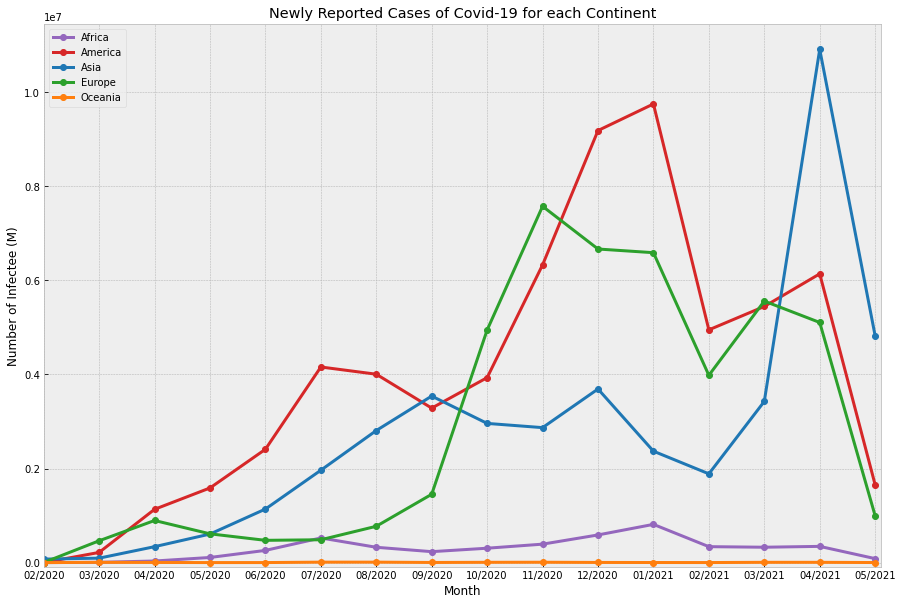

In [11]:
continent_list = continent_new_case['CONTINENT_NAME'].unique()
color_list = ['tab:purple', 'tab:red', 'tab:blue', 'tab:green', 'tab:orange']
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = [15, 10]

# use for loop to create a line graph for each continent
for continent, color in zip(continent_list, color_list):
    plt.plot('MONTH_YEAR', 'Confirmed_Cases', data=continent_new_case.loc[continent_new_case['CONTINENT_NAME']==continent],
             c=color, label=continent, marker='o', linewidth=3)

plt.legend()
plt.ylim(-100000, max(continent_new_case['Confirmed_Cases'])*1.05)
plt.xlim(1, len(continent_new_case['MONTH_YEAR'].unique()) - 0.9)
plt.xlabel('Month')
plt.title('Newly Reported Cases of Covid-19 for each Continent')
plt.ylabel('Number of Infectee (M)')
plt.show()

To be clear each plot **doesn't** represent the sum of monthly cases. It's a quantity of newly reported cases.

## Observations
* Both America and Europe experienced fast growth from Sep 2020 to Jan 2020
* The immediate impact of vaccination in Jan 2021 can be observed with the sharp decline of newly reported cases in Feb 2021
* The steepest slope is Asia's March 2021 - April 2021

In [14]:
# create a list of total of new cases for each time period
aggregate_dict = dict()

case_tracker = 0
for continent in continent_list:
    aggregate_list = []
    ## forming a dict of aggregate cases by timeline (monthly)
    monthly_cases = continent_new_case.loc[continent_new_case['CONTINENT_NAME'] == continent]['Confirmed_Cases']
    for case in monthly_cases:
        case_tracker += case
        aggregate_list.append(case_tracker)
    case_tracker = 0
    aggregate_dict[continent] = aggregate_list

#this is to add it to continent_new_case 
all_aggregate_list = []
for continent in aggregate_dict:
    all_aggregate_list += aggregate_dict[continent]

continent_new_case['AGGREGATE_CASES'] = all_aggregate_list
print(aggregate_dict)

{'Africa': [0, 3, 6122, 39712, 148729, 408030, 931702, 1257215, 1489709, 1795501, 2187561, 2775325, 3587848, 3926588, 4253311, 4598139, 4682638], 'America': [11, 98, 216422, 1349018, 2935619, 5344659, 9502453, 13506784, 16790674, 20722428, 27050578, 36234653, 45983724, 50931007, 56375435, 62513656, 64166434], 'Asia': [9889, 83719, 178093, 516555, 1123219, 2261210, 4224922, 7032174, 10571874, 13530609, 16399404, 20089508, 22457925, 24344830, 27771020, 38680825, 43500736], 'Europe': [17, 1507, 465339, 1360235, 1971669, 2444896, 2930193, 3702101, 5154673, 10098899, 17672770, 24338504, 30926259, 34907683, 40466272, 45570580, 46564825], 'Oceania': [9, 26, 5264, 8347, 8811, 9560, 19025, 28654, 31389, 37477, 45098, 48404, 50165, 51171, 57062, 62896, 64206]}


### go on from here

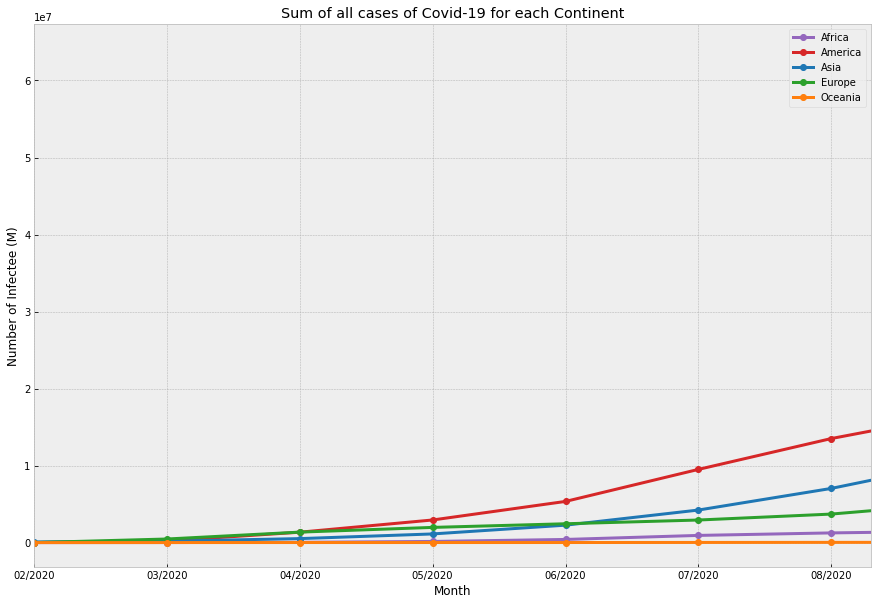

In [15]:
for continent, color in zip(continent_list, color_list):
    plt.plot('MONTH_YEAR', 'AGGREGATE_CASES', data=continent_new_case.loc[continent_new_case['CONTINENT_NAME']==continent], c=color, label=continent, marker='o', linewidth=3)

max_continent = []
for continent in continent_list:
    max_continent.append(continent_new_case.loc[(continent_new_case['CONTINENT_NAME'] == continent) & 
                                                (continent_new_case['MONTH'] == 7)]['AGGREGATE_CASES'].sum())

    # for y in max_continent:
#     if y >= 1000000:
#         plt.text(7.05, y, str(round(y/1000000, 2)) +'M')
#     else:
#         plt.text(7.05, y, str(round(y/1000)) +'K')

plt.legend()
plt.xlabel('Month')
plt.xlim(1, 7.3)
plt.title('Sum of all cases of Covid-19 for each Continent')
plt.ylabel('Number of Infectee (M)')
plt.show()

* America is by far the *most* dangerous continent to travel in the current state - **fastest growth rate** since March
* Asia and Africa are experiencing a steady increase
* Europe and Oceania are managing to flatten the curves

### Counting Deaths of each Continent

In [ ]:
continent_death = covid[['CONTINENT_NAME', 'PEOPLE_DEATH_NEW_COUNT', 'YEAR', 'MONTH']].groupby(
                       ['CONTINENT_NAME','YEAR', 'MONTH'], as_index=False).sum()
continent_death = continent_death.append({'CONTINENT_NAME':'Africa', 'YEAR':2020, 'MONTH':1, 'PEOPLE_DEATH_NEW_COUNT':0}, ignore_index=True)
continent_death.drop(index=13, inplace=True)
continent_death.sort_values(by=['CONTINENT_NAME', 'MONTH'], inplace=True)
continent_death.reset_index(drop=True, inplace=True)

DEATH_AGGREGATE = []
death_count = 0
for continent in continent_list:
    for item, death in zip(continent_death['CONTINENT_NAME'], continent_death['PEOPLE_DEATH_NEW_COUNT']):
        if continent == item:
            death_count += death
            DEATH_AGGREGATE.append(death_count)
        else:
            death_count = 0
continent_death['DEATH_AGGREGATE'] = DEATH_AGGREGATE
print(continent_death)

In [ ]:
for continent, color in zip(continent_list, color_list):
    plt.plot('MONTH', 'DEATH_AGGREGATE', data=continent_death.loc[continent_death['CONTINENT_NAME']==continent], c=color, label=continent, marker='o', linewidth=3)

max_death = []
for continent in continent_list:
    max_death.append(continent_death.loc[(continent_death['CONTINENT_NAME'] == continent) & 
                                                (continent_death['MONTH'] == 7)]['DEATH_AGGREGATE'].sum())

for y in max_death:
    if y >= 1000:
        plt.text(7.05, y, str(round(y/1000)) +'K')
    else:
        plt.text(7.05, y, str(y))
plt.legend()
plt.xlim(1, 7.3)
plt.xlabel('Month')
plt.title('Death Toll for each Continent')
yticks = [50000, 100000, 150000, 200000, 250000, 300000, 350000]
ylabels = ['50K', '100K', '150K', '200K', '250K', '300K', '350K']
plt.yticks(ticks=yticks, labels=ylabels)
plt.ylabel('Fatality')
plt.show()

* As observed from previous graphs, the decline of Covid-19's positive cases in Europe has resulted in gentler slopes after April
* The extreme growth rate of positive cases in America is reflected by the steep slope on this graph
* Although the total of positive cases in Asia is greater than that of Europe by 80,000, death toll is much lower (it could be the consequence of how well the countries handled the situation)

### Mortality Rate

In [ ]:
def death_rate(df, continent):
    '''
    Args:
        df: DataFrame
        header: str or a list of str, a header of a column 
    Return:
         death rate of a continent or an average death rate of continents
    '''
    # if calculating death rate of a continent, find the lastest updates of death and infected population
    if type(continent) == str:
        temp = df.loc[df['CONTINENT_NAME'] == continent]
        return '{}%'.format(round(temp['PEOPLE_DEATH_COUNT'].max()/temp['PEOPLE_POSITIVE_CASES_COUNT'].max()*100, 2))
    # if calculating death rate of continents, find each continent's death rate and find the average
    else:
        death = []
        population = []
        total = 0
        for item in continent:
            death.append(df.loc[df['CONTINENT_NAME'] == item]['PEOPLE_DEATH_COUNT'].max())
            population.append(df.loc[df['CONTINENT_NAME'] == item]['PEOPLE_POSITIVE_CASES_COUNT'].max())
        for d, p in zip(death, population):
            total += d/p*100
        return '{}%'.format(round(total/len(death), 2))

print(death_rate(covid,'Africa'))
print(death_rate(covid,'America'))
print(death_rate(covid,['Africa', 'America']))

In [ ]:
for continent in continent_list:
    print(f"Mortality rate of Covid-19 in {continent}: {death_rate(covid, continent)}")
print(f'===============\nAverage mortality rate of Covid-19: {death_rate(covid, continent_list)}')

*Europe* has recorded the highest mortality rate of **5.77%** while *Oceania* has managed the lowest of **0.99%**.

Overall, the average is **2.88%**, which is considered **not fatal**.

In [ ]:
total_all = covid[['MONTH', 'PEOPLE_POSITIVE_NEW_CASES_COUNT', 'PEOPLE_DEATH_NEW_COUNT']].groupby(['MONTH']).sum()
total_all.drop(12, inplace=True)
total_positive_list = []
total_death_list = []
count_positive = 0
count_death = 0
for positive, death in zip(total_all['PEOPLE_POSITIVE_NEW_CASES_COUNT'], total_all['PEOPLE_DEATH_NEW_COUNT']):
    count_positive += positive
    count_death += death
    total_positive_list.append(count_positive)
    total_death_list.append(count_death)
total_all['TOTAL_POSITIVE_CASE'] = total_positive_list
total_all['TOTAL_DEATH'] = total_death_list
print(total_all)

In [ ]:
total_all['TOTAL_POSITIVE_CASE'].plot(linewidth=3, marker='o')
plt.title('All Positive Cases of Covid-19')
#setting up y-axis and x-axis of all positive cases
plt.xlim(1, 7.3)
plt.ylim(-100000, 16000000)
yticks = [0, 2000000, 4000000, 6000000, 8000000, 10000000, 12000000, 14000000, 16000000]
ylabels = ['0', '2M', '4M', '6M', '8M', '10M', '12M', '14M', '16M']
plt.yticks(ticks=yticks, labels=ylabels)
y = total_all['TOTAL_POSITIVE_CASE'].max()
plt.text(6.85, y+200000, str(y))
plt.show()

total_all['TOTAL_DEATH'].plot(linewidth=3, marker='o')
plt.title('International Death Toll')
#setting up y-axis and x-axis of death toll
plt.xlim(1, 7.3)
plt.ylim(-10000, 700000)
yticks = [0, 100000, 200000, 300000, 400000, 500000, 600000, 700000]
ylabels = ['0', '100K', '200K', '300K', '400K', '500K', '600K', '700k']
plt.yticks(ticks=yticks, labels=ylabels)
y = total_all['TOTAL_DEATH'].max()
plt.text(6.9, y+10000, str(y))
plt.show()

In [ ]:
covid['REPORT_DATE'] = pd.to_datetime(covid['REPORT_DATE'])
covid.sort_values(by='REPORT_DATE', inplace=True)

### Plotting every point

In [ ]:
covid_daily = covid.groupby('REPORT_DATE', as_index=False).sum()
plt.plot_date(x=covid_daily['REPORT_DATE'], y=covid_daily['PEOPLE_POSITIVE_CASES_COUNT'])
yticks = [0, 2000000, 4000000, 6000000, 8000000, 10000000, 12000000, 14000000, 16000000]
ylabels = ['0', '2M', '4M', '6M', '8M', '10M', '12M', '14M', '16M']
plt.yticks(ticks=yticks, labels=ylabels)
plt.title('The Tracks of Covid-19')
plt.show()

Why is the last point out of place?

Since this graph is reporting the aggregate of all reported cases in the past, the last point cannot be where it is plotted.

Let's investigate

### Tracking down the problem

In [ ]:
print(covid_daily.tail(2))

In [ ]:
print(covid.loc[covid['REPORT_DATE']=='2020-07-23']['PEOPLE_POSITIVE_CASES_COUNT'].isnull().sum())
print(covid.loc[covid['REPORT_DATE'].isin(['2020-07-23', '2020-07-22'])]
              [['PEOPLE_POSITIVE_CASES_COUNT', 'CONTINENT_NAME', 'REPORT_DATE']]
              .groupby(['CONTINENT_NAME', 'REPORT_DATE']).sum())

In America, cases went from 8026207 to 4037927. Given it happened within a day, the number should've been more like 8037927

Let's see where in America it happened

In [ ]:
pd.set_option('display.max_rows', None)
print(covid.loc[(covid['REPORT_DATE'].isin(['2020-07-23', '2020-07-22'])) & (covid['CONTINENT_NAME'] == 'America')]
[['PEOPLE_POSITIVE_CASES_COUNT', 'COUNTRY_SHORT_NAME', 'REPORT_DATE']].groupby(['COUNTRY_SHORT_NAME', 'REPORT_DATE']).sum())

Everywhere looks fine except the U.S.

It was due to missing 2020-07-23 reports in the U.S.

Since the total on 2020-07-23 is highly affected by this factor, I'm going to graph til 2020-07-22

In [ ]:
# drop the reports on 2020-07-23
covid_temp = covid.copy()
covid_temp.drop(covid_temp.loc[covid_temp['REPORT_DATE'] == '2020-07-23'].index, inplace=True)
covid_daily = covid_temp.groupby('REPORT_DATE', as_index=False).sum()
plt.plot_date(x=covid_daily['REPORT_DATE'], y=covid_daily['PEOPLE_POSITIVE_CASES_COUNT'])
yticks = [0, 2000000, 4000000, 6000000, 8000000, 10000000, 12000000, 14000000, 16000000]
ylabels = ['0', '2M', '4M', '6M', '8M', '10M', '12M', '14M', '16M']
plt.yticks(ticks=yticks, labels=ylabels)
plt.title('The Tracks of Covid-19')
plt.show()

Now it looks great with no error

In [ ]:
covid_daily = covid.groupby('REPORT_DATE', as_index=False).sum()
covid_daily.drop(covid_temp.loc[covid_temp['REPORT_DATE'] == '2020-07-23'].index, inplace=True)
plt.plot_date(x=covid_daily['REPORT_DATE'], y=covid_daily['PEOPLE_POSITIVE_CASES_COUNT'])
yticks = [0, 2000000, 4000000, 6000000, 8000000, 10000000, 12000000, 14000000, 16000000]
ylabels = ['0', '2M', '4M', '6M', '8M', '10M', '12M', '14M', '16M']
plt.yticks(ticks=yticks, labels=ylabels)
plt.title('The Tracks of Covid-19')
plt.show()